In [20]:
#Importing libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
import seaborn as sns
import os

# For Leiden:
import igraph as ig
import leidenalg

# display settings
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 8)
sns.set()

In [4]:
#Loading the country's relationship file 
csv_path = "country_relationships_counts.csv" 
df = pd.read_csv(csv_path)
# Show top rows and columns
df.head(), df.columns.tolist()

(  Country1 Country2  Count
 0    China   France      1
 1    China    India      2
 2    China    Japan      2
 3    China   Russia      1
 4   France  Germany      1,
 ['Country1', 'Country2', 'Count'])

In [6]:
#Creating network object from df 
src_col = 'Country1'
tgt_col = 'Country2'
weight_col = 'Count'

#Creating edges with weights
edges = list(df[[src_col, tgt_col, weight_col]].itertuples(index=False, name=None))

G = nx.Graph()
G.add_weighted_edges_from(edges)

print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

Nodes: 8, Edges: 14


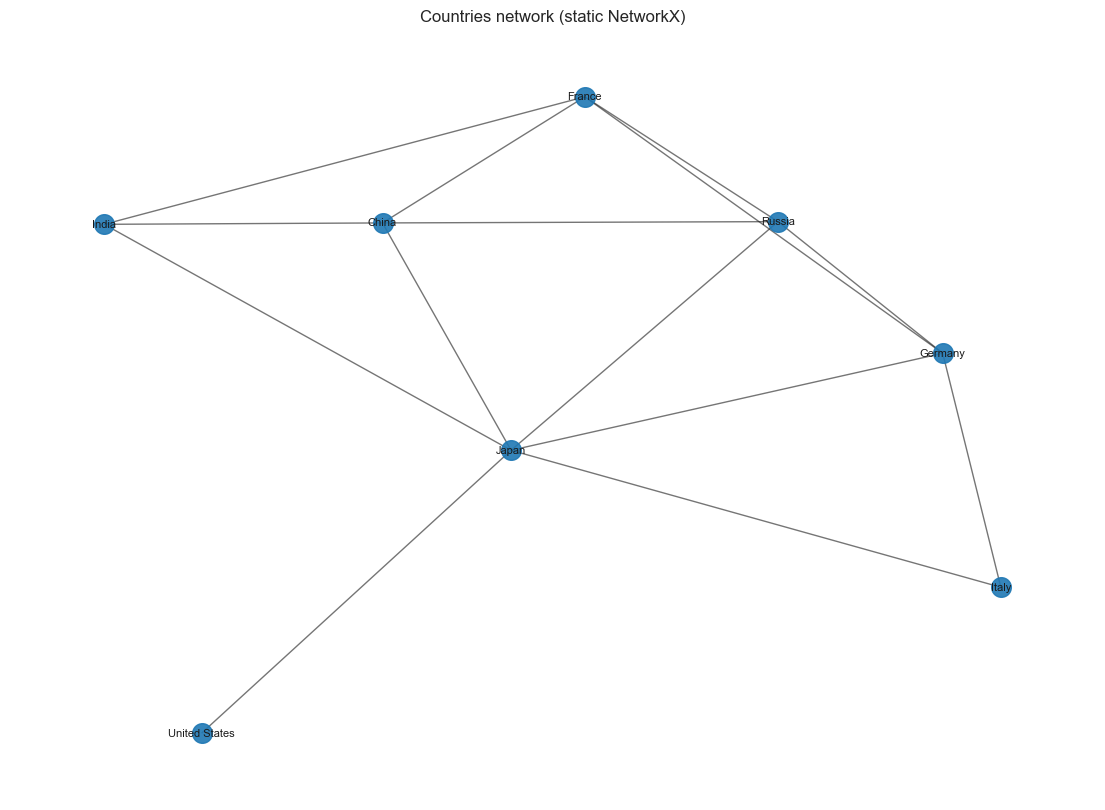

In [12]:
#Creating static network graph using NetworkX.
plt.figure(figsize=(14,10))
pos = nx.spring_layout(G, seed=42, k=0.5)
nx.draw_networkx_nodes(G, pos, node_size=200, alpha=0.9)
nx.draw_networkx_edges(G, pos, alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Countries network (static NetworkX)")
plt.axis('off')
plt.show()

In [8]:
#Interactive Pyvis visualization
pyvis_net = Network(height="800px", width="100%", notebook=True, bgcolor="#ffffff", font_color="black")
pyvis_net.from_nx(G)
pyvis_net.show_buttons(filter_=['physics'])

output_html1 = "countries_network_interactive.html"
pyvis_net.show(output_html1)
print(f"Saved interactive network to {output_html1}")

countries_network_interactive.html
Saved interactive network to countries_network_interactive.html


In [14]:
#Applying the Leiden algorithm to detect any communities
nodes = list(G.nodes())
node_to_idx = {n:i for i,n in enumerate(nodes)}
edges_ig = [(node_to_idx[u], node_to_idx[v]) for u,v in G.edges()]
g_ig = ig.Graph(n=len(nodes), edges=edges_ig, directed=False)

#Adding weights
weights = [G[u][v].get('weight', 1.0) for u,v in G.edges()]
g_ig.es['weight'] = weights

partition = leidenalg.find_partition(g_ig, leidenalg.RBConfigurationVertexPartition, weights=g_ig.es['weight'])
membership = partition.membership
community_map = {nodes[i]: membership[i] for i in range(len(nodes))}
num_communities = len(set(membership))
print(f"Found {num_communities} communities")

Found 2 communities


In [17]:
#importing cm
from matplotlib import cm

/var/folders/wf/s0crnzgd66b7pdj9_7_b6mpw0000gn/T/ipykernel_91814/3802553611.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = cm.get_cmap('tab20', num_communities)


countries_network_communities.html
Saved community network to countries_network_communities.html


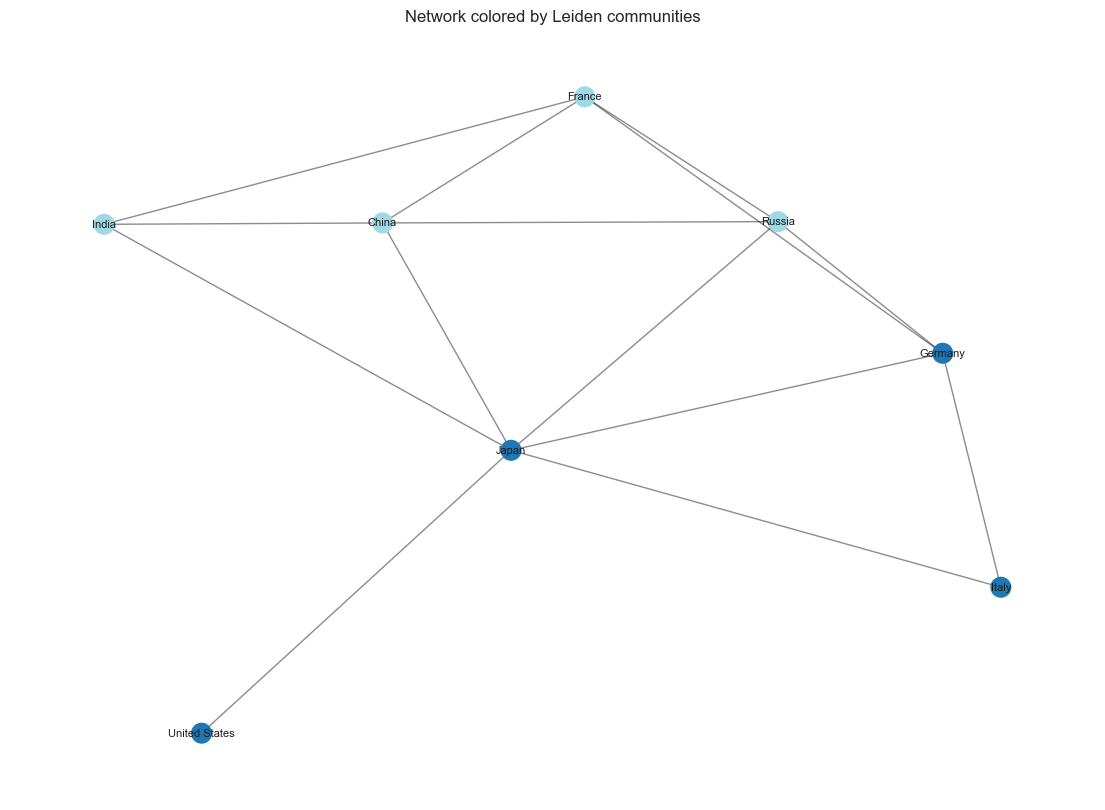

In [18]:
#Visualizing the communities 
palette = cm.get_cmap('tab20', num_communities)

# interactive pyvis
pyvis_comm = Network(height="900px", width="100%", notebook=True, bgcolor="#ffffff", font_color="black")
for n in G.nodes():
    comm = community_map[n]
    color = '#' + ''.join(f"{int(255*c):02x}" for c in palette(comm)[:3])
    pyvis_comm.add_node(n, label=str(n), title=f"{n} (comm {comm})", color=color)

for u,v,data in G.edges(data=True):
    w = data.get('weight', 1)
    pyvis_comm.add_edge(u, v, value=w)

pyvis_comm.show_buttons(filter_=['physics'])
output_html2 = "countries_network_communities.html"
pyvis_comm.show(output_html2)
print(f"Saved community network to {output_html2}")

# static plot
colors_hex = ['#' + ''.join(f"{int(255*c):02x}" for c in palette(community_map[n])[:3]) for n in nodes]
plt.figure(figsize=(14,10))
nx.draw_networkx_nodes(G, pos, node_color=colors_hex, node_size=200)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Network colored by Leiden communities")
plt.axis('off')
plt.show()

In [21]:
#Calculating centrality 
deg_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, normalized=True)

import pandas as pd
centrality_df = pd.DataFrame({
    'Country': list(G.nodes()),
    'Degree': [deg_centrality[n] for n in G.nodes()],
    'Closeness': [closeness_centrality[n] for n in G.nodes()],
    'Betweenness': [betweenness_centrality[n] for n in G.nodes()],
    'Community': [community_map[n] for n in G.nodes()]
})
centrality_df.sort_values('Degree', ascending=False).head(15)

,Country,Degree,Closeness,Betweenness,Community
3,Japan,0.857143,0.875000,0.460317,0
0,China,0.571429,0.700000,0.039683,1
1,France,0.571429,0.636364,0.055556,1
4,Russia,0.571429,0.700000,0.039683,1
5,Germany,0.571429,0.700000,0.095238,0
2,India,0.428571,0.636364,0.023810,1
6,Italy,0.285714,0.583333,0.000000,0
7,United States,0.142857,0.500000,0.000000,0
